In [1]:
import os
if  not 'juxtorpus' in os.listdir():
    os.chdir('../')
assert 'juxtorpus' in os.listdir(), f"Working directory should be at juxtorpus. But at {os.getcwd()}"
f"Working directory: {os.getcwd()}"

'Working directory: /Users/hcha9747/workspace/juxtorpus'

In [2]:
from juxtorpus.corpus import Corpus, CorpusBuilder

import re

tweet_wrapper = re.compile(r'([ ]?<[/]?TWEET>[ ]?)')

builder = CorpusBuilder('/Users/hcha9747/Downloads/Geolocated_places_climate_with_LGA_and_remoteness_with_text.csv')
builder.set_text_column('text')
# builder.set_nrows(None)
builder.set_preprocessors([lambda text: tweet_wrapper.sub('', text)])
builder.add_meta('tweet_lga')
builder.add_meta('year')
builder.add_meta('month')
builder.add_meta('day')
display(builder.show_columns())
corpus = builder.build()
corpus.summary()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
All Columns,year,month,day,lat_mid,lon_mid,screen_name,tweet_id,retweet,text,geometry,tweet_lga,lga_code_2020,lga_name_2020,state_code_2016,state_name_2016,remoteness,remote_level
Added,tweet_lga,year,month,day,,,,,,,,,,,,,


Number of words           1279576
Number of unique words      66244
Number of documents         50235
Name: frequency, dtype: uint64

In [3]:
from juxtorpus.corpus import CorpusSlicer
slicer = CorpusSlicer(corpus)
corpus = slicer.filter_by_item('tweet_lga', ['Sunshine Coast (R)', 'Broken Hill (C)'])
corpus.summary()   # only with Sunshine Coast & Broken Hill

Number of words           26415
Number of unique words     5388
Number of documents        1229
Name: frequency, dtype: uint64

In [4]:
corpus.metas().keys()

dict_keys(['tweet_lga', 'month', 'day', 'year'])

In [5]:
# Let's process this subset
from juxtorpus.corpus.processors import SpacyProcessor
import spacy

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('extract_hashtags')
spacy_processor = SpacyProcessor(nlp)
corpus = spacy_processor.run(corpus)

corpus.metas().keys()

dict_keys(['tweet_lga', 'month', 'day', 'year', 'ner', 'extract_hashtags'])

In [6]:
slicer = CorpusSlicer(corpus)

A = slicer.filter_by_item('tweet_lga', 'Sunshine Coast (R)')
B = slicer.filter_by_item('tweet_lga', 'Broken Hill (C)')

import pandas as pd
summ = pd.concat([A.summary().rename("corpus A"),(B.summary().rename("corpus B"))], axis=1)
summ['diff'] = summ['corpus A'] - summ['corpus B']
summ

,corpus A,corpus B,diff
Number of words,16934,7430,9504
Number of unique words,3789,1976,1813
Number of documents,680,549,131


[WARNING] Plotting 30 words may lag as there is a lot to render. Try a number < 25 with set_top()


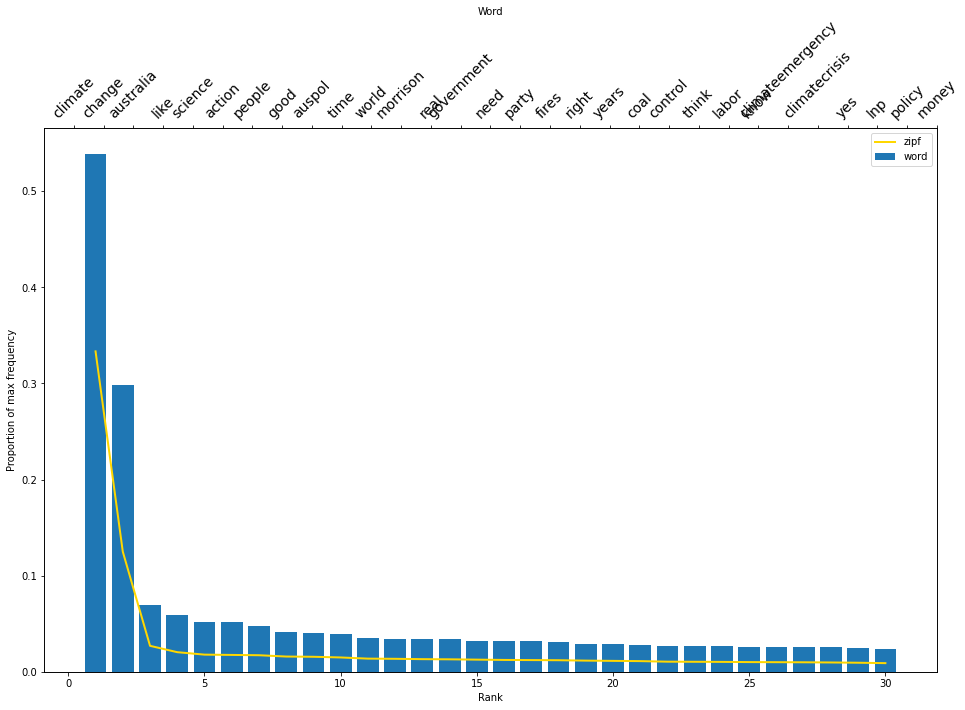

In [7]:
from juxtorpus.features.zipf import Zipf
from spacy.lang.en.stop_words import STOP_WORDS

A_zipf = Zipf(A).set_top(30)
with A_zipf.remove_words(STOP_WORDS) as A_zipff:
    A_zipff.render()

[WARNING] Plotting 30 words may lag as there is a lot to render. Try a number < 25 with set_top()


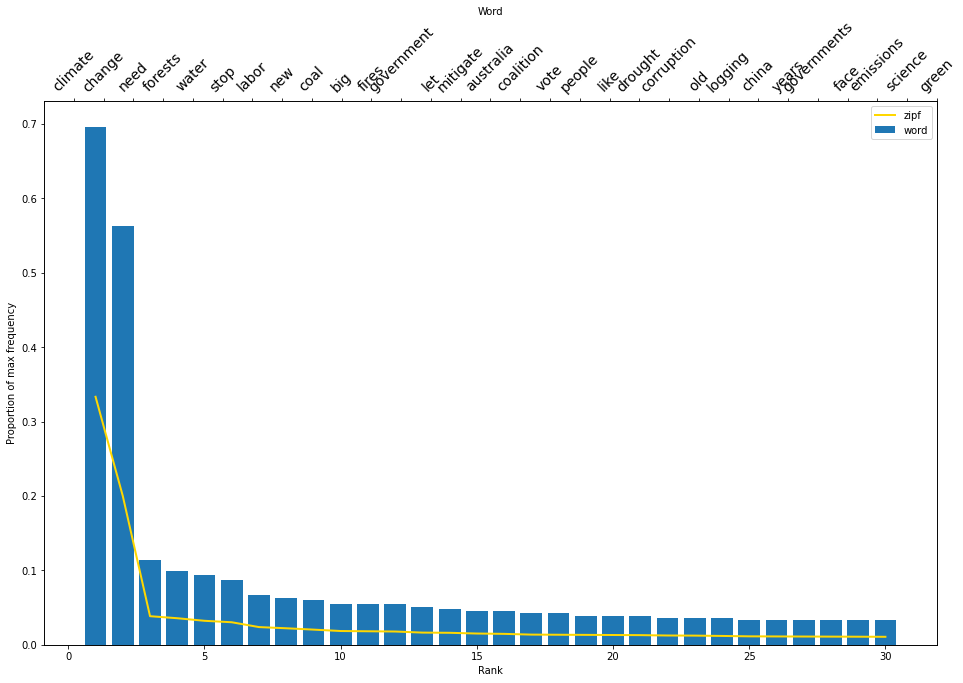

In [8]:
B_zipf = Zipf(B).set_top(30)
with B_zipf.remove_words(STOP_WORDS) as B_zipff:
    B_zipff.render()

# Keywords

Keywords (1-gram) scores are based on term frequencies.
The equation is...
1. term_freq
2. if normalised = term_freq / num_words_in_corpus
3. if log = log(term_freq) / log(num_words_in_corpus)

In [16]:
from juxtorpus.features.keywords import TFKeywords
# A = Sunshine Coast
# B = Broken Hill

# climate climate climate climate
A_tf = TFKeywords(A).freq_threshold(2).normalise(True).log_freqs(False)
B_tf = TFKeywords(B).freq_threshold(2).normalise(True).log_freqs(False)
list(zip(A_tf.extracted()[:10], B_tf.extracted()[:10]))

[(('climate', 2.5628912247549307), ('climate', 3.095558546433378)),
 (('change', 1.429077595370261), ('change', 2.503364737550471)),
 (('australia', 0.3366009212235739), ('need', 0.49798115746971733)),
 (('like', 0.2834534073461675), ('forests', 0.43068640646029605)),
 (('action', 0.24211645210818472), ('water', 0.41722745625841184)),
 (('science', 0.23621117278847292), ('stop', 0.39030955585464333)),
 (('people', 0.2303058934687611), ('labor', 0.2960969044414536)),
 (('auspol', 0.19487421755049014), ('new', 0.2826379542395693)),
 (('good', 0.19487421755049014), ('coal', 0.2691790040376851)),
 (('time', 0.18896893823077832), ('fires', 0.24226110363391654))]

## Polarity Word Cloud

There are 2 parts to this word cloud. 
1. The colour of the words show the polarity towards either corpus. 

**(Here RED = Sunshine Coast, BLUE = Broken Hill)**

2. The size of the words are highly polarised AND make frequent words that are in **BOTH** corpus smaller.

the score is calculated as abs(relative)/summed.

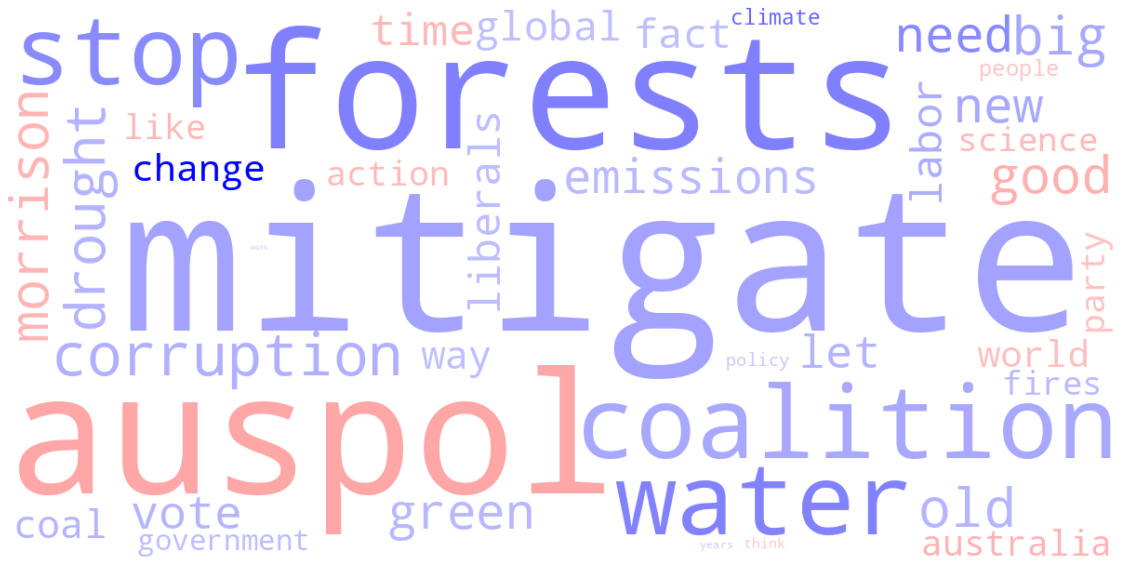

In [17]:
from juxtorpus.viz.polarity_wordcloud import PolarityWordCloud

pwc = PolarityWordCloud.from_(A_tf.extracted(), B_tf.extracted())
pwc.top(40).gradate('red', 'blue').render(20, 32)

In [18]:
pwc._df.head(40).sort_values(by='relative_div_summed_', ascending=False)

,score_A,score_B,relative_,summed_,relative_div_summed_,relative_mul_summed_,relative_normalised_
word,,,,,,,
auspol,0.194874,0.000000,0.194874,0.194874,1.000000,0.037976,1.590699
mitigate,0.000000,0.215343,-0.215343,0.215343,1.000000,0.046373,1.399774
forests,0.023621,0.430686,-0.407065,0.454308,0.896013,0.184933,1.310542
coalition,0.011811,0.201884,-0.190074,0.213695,0.889463,0.040618,1.411535
water,0.029526,0.417227,-0.387701,0.446754,0.867818,0.173207,1.319554
stop,0.041337,0.390310,-0.348973,0.431647,0.808468,0.150633,1.337579
corruption,0.023621,0.174966,-0.151345,0.198587,0.762109,0.030055,1.429560
drought,0.035432,0.174966,-0.139535,0.210398,0.663194,0.029358,1.435057
old,0.035432,0.161507,-0.126076,0.196939,0.640176,0.024829,1.441321


<AxesSubplot:xlabel='word'>

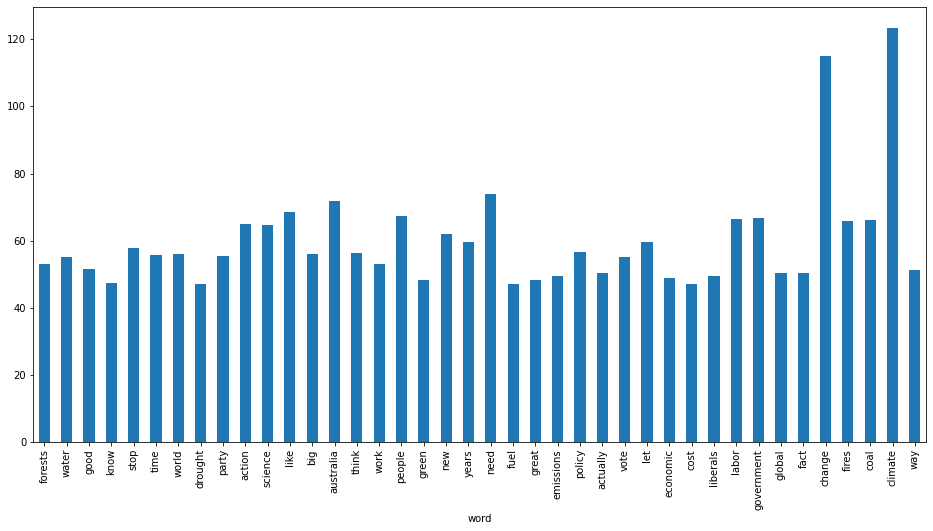

In [12]:
pwc._df.head(40).sort_values(by='relative_div_summed_', ascending=False).summed_.plot.bar(figsize=(16, 8))

<AxesSubplot:xlabel='word'>

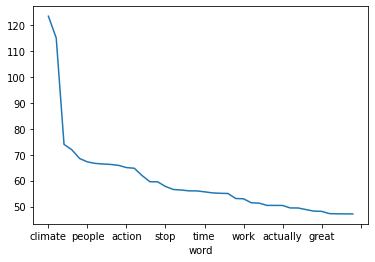

In [13]:
pwc._df.head(40)['summed_'].plot()

<AxesSubplot:xlabel='word'>

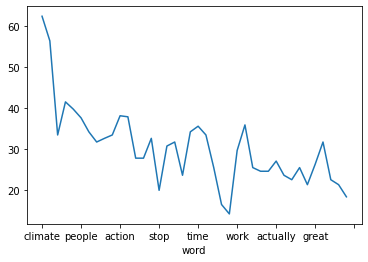

In [14]:
pwc._df.head(40)['score_A'].plot()

In [15]:
corpus.get_meta('extract_hashtags')

<DocMeta [Id: extract_hashtags, Attribute: hashtags]